In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import graphviz
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

# YOLO 모델 아키텍처 시각화 클래스
class YOLOArchitectureVisualizer:
    def __init__(self, model_path):
        """
        YOLO 모델 아키텍처 시각화기 초기화
        
        Args:
            model_path (str): 학습된 YOLO .pt 파일 경로
        """
        self.model_path = Path(model_path)
        self.model = None
        self.model_info = {}
        
        if not self.model_path.exists():
            raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {model_path}")
            
        self.load_model()
        
    def load_model(self):
        """모델 로드 및 기본 정보 수집"""
        try:
            # YOLO 모델 로드
            checkpoint = torch.load(self.model_path, map_location='cpu', weights_only=False)
            
            # 모델 정보 추출
            if 'model' in checkpoint:
                self.model = checkpoint['model']
                if hasattr(self.model, 'float'):
                    self.model = self.model.float()
            else:
                # 직접 모델인 경우
                self.model = checkpoint
                
            # 모델을 evaluation 모드로 설정
            if hasattr(self.model, 'eval'):
                self.model.eval()
                
            # 모델 기본 정보 수집
            self.collect_model_info(checkpoint)
            
            print(f"✅ 모델 로드 완료: {self.model_path.name}")
            print(f"📊 모델 타입: {type(self.model).__name__}")
            
        except Exception as e:
            print(f"❌ 모델 로드 실패: {e}")
            raise
            
    def collect_model_info(self, checkpoint):
        """모델 정보 수집"""
        self.model_info = {
            'file_size_mb': self.model_path.stat().st_size / (1024 * 1024),
            'total_params': 0,
            'trainable_params': 0,
            'non_trainable_params': 0,
            'layers': []
        }
        
        # 체크포인트에서 추가 정보 추출
        if isinstance(checkpoint, dict):
            for key in ['epoch', 'best_fitness', 'model', 'optimizer', 'ema']:
                if key in checkpoint:
                    if key == 'model':
                        continue  # 모델은 따로 처리
                    self.model_info[key] = str(checkpoint[key])[:100]  # 긴 내용은 자르기
                    
        # 파라미터 수 계산
        if hasattr(self.model, 'parameters'):
            for param in self.model.parameters():
                param_count = param.numel()
                self.model_info['total_params'] += param_count
                if param.requires_grad:
                    self.model_info['trainable_params'] += param_count
                else:
                    self.model_info['non_trainable_params'] += param_count
                    
    def print_model_summary(self):
        """모델 요약 정보 출력"""
        print("=" * 60)
        print("🔍 YOLO 모델 아키텍처 요약")
        print("=" * 60)
        
        print(f"📁 파일명: {self.model_path.name}")
        print(f"💾 파일 크기: {self.model_info['file_size_mb']:.2f} MB")
        print(f"🔢 총 파라미터 수: {self.model_info['total_params']:,}")
        print(f"🔧 학습 가능한 파라미터: {self.model_info['trainable_params']:,}")
        print(f"🔒 고정된 파라미터: {self.model_info['non_trainable_params']:,}")
        
        # 추가 정보 출력
        for key, value in self.model_info.items():
            if key not in ['file_size_mb', 'total_params', 'trainable_params', 'non_trainable_params', 'layers']:
                print(f"📋 {key}: {value}")
        
        print("=" * 60)
        
    def visualize_layer_structure(self):
        """레이어 구조 시각화"""
        if not hasattr(self.model, 'model'):
            print("⚠️ 모델의 세부 레이어 정보에 접근할 수 없습니다.")
            return
            
        print("\n🏗️ 모델 레이어 구조:")
        print("-" * 80)
        
        layer_info = []
        
        def analyze_module(module, name="", depth=0):
            indent = "  " * depth
            module_type = type(module).__name__
            
            # 파라미터 수 계산
            params = sum(p.numel() for p in module.parameters() if p.requires_grad)
            
            # 출력 형태 정보
            output_shape = "N/A"
            if hasattr(module, 'weight') and module.weight is not None:
                if len(module.weight.shape) >= 2:
                    output_shape = f"{module.weight.shape}"
                    
            layer_info.append({
                'name': name or module_type,
                'type': module_type,
                'params': params,
                'depth': depth,
                'output_shape': output_shape
            })
            
            print(f"{indent}📦 {name or module_type} ({module_type})")
            if params > 0:
                print(f"{indent}   └─ 파라미터: {params:,}")
            if hasattr(module, 'in_channels') and hasattr(module, 'out_channels'):
                print(f"{indent}   └─ 채널: {module.in_channels} → {module.out_channels}")
            if hasattr(module, 'kernel_size'):
                print(f"{indent}   └─ 커널 크기: {module.kernel_size}")
            if hasattr(module, 'stride'):
                print(f"{indent}   └─ 스트라이드: {module.stride}")
                
        # 모델 구조 분석
        if hasattr(self.model, 'model'):
            for i, module in enumerate(self.model.model):
                analyze_module(module, f"Layer_{i}", 0)
                if hasattr(module, 'children'):
                    for j, child in enumerate(module.children()):
                        analyze_module(child, f"  └─ {type(child).__name__}_{j}", 1)
        else:
            for name, module in self.model.named_children():
                analyze_module(module, name, 0)
                
        return layer_info
        
    def plot_parameter_distribution(self):
        """파라미터 분포 시각화"""
        if not hasattr(self.model, 'named_parameters'):
            print("⚠️ 모델 파라미터에 접근할 수 없습니다.")
            return
            
        # 파라미터 정보 수집
        layer_names = []
        param_counts = []
        layer_types = []
        
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                layer_names.append(name.split('.')[-2] if '.' in name else name)
                param_counts.append(param.numel())
                # 레이어 타입 추정
                if 'conv' in name.lower():
                    layer_types.append('Conv')
                elif 'bn' in name.lower() or 'batch' in name.lower():
                    layer_types.append('BatchNorm')
                elif 'linear' in name.lower() or 'fc' in name.lower():
                    layer_types.append('Linear')
                else:
                    layer_types.append('Other')
        
        # 시각화
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # 파라미터 수 막대 그래프
        colors = plt.cm.Set3(np.linspace(0, 1, len(param_counts)))
        bars = ax1.bar(range(len(param_counts)), param_counts, color=colors)
        ax1.set_title('📊 레이어별 파라미터 수', fontsize=14, fontweight='bold')
        ax1.set_xlabel('레이어 인덱스')
        ax1.set_ylabel('파라미터 수')
        ax1.tick_params(axis='x', rotation=45)
        
        # 값 표시
        for i, (bar, count) in enumerate(zip(bars, param_counts)):
            if count > max(param_counts) * 0.1:  # 큰 값만 표시
                ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(param_counts)*0.01,
                        f'{count:,}', ha='center', va='bottom', fontsize=8)
        
        # 레이어 타입별 파이 차트
        type_counts = {}
        for layer_type, param_count in zip(layer_types, param_counts):
            type_counts[layer_type] = type_counts.get(layer_type, 0) + param_count
            
        ax2.pie(type_counts.values(), labels=type_counts.keys(), autopct='%1.1f%%', startangle=90)
        ax2.set_title('🥧 레이어 타입별 파라미터 분포', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # 통계 출력
        print(f"\n📈 파라미터 통계:")
        print(f"   • 평균 파라미터/레이어: {np.mean(param_counts):,.0f}")
        print(f"   • 최대 파라미터 레이어: {max(param_counts):,}")
        print(f"   • 최소 파라미터 레이어: {min(param_counts):,}")
        
    def create_architecture_graph(self, save_path=None):
        """아키텍처 그래프 생성 (Graphviz 사용)"""
        try:
            dot = graphviz.Digraph(comment='YOLO Architecture')
            dot.attr(rankdir='TB', size='10,12')
            dot.attr('node', shape='box', style='rounded,filled', fontname='Arial')
            
            # 입력 노드
            dot.node('input', 'Input\n(Images)', fillcolor='lightblue')
            
            # 모델 레이어 노드 생성
            prev_node = 'input'
            
            if hasattr(self.model, 'model'):
                for i, module in enumerate(self.model.model):
                    node_name = f'layer_{i}'
                    module_type = type(module).__name__
                    
                    # 노드 색상 설정
                    if 'Conv' in module_type:
                        color = 'lightgreen'
                    elif 'Pool' in module_type:
                        color = 'lightyellow'
                    elif 'BatchNorm' in module_type or 'BN' in module_type:
                        color = 'lightcoral'
                    elif 'Linear' in module_type:
                        color = 'lightpink'
                    else:
                        color = 'lightgray'
                    
                    # 레이어 정보
                    label = f'{module_type}\\n({i})'
                    if hasattr(module, 'in_channels') and hasattr(module, 'out_channels'):
                        label += f'\\n{module.in_channels}→{module.out_channels}'
                    
                    dot.node(node_name, label, fillcolor=color)
                    dot.edge(prev_node, node_name)
                    prev_node = node_name
            
            # 출력 노드
            dot.node('output', 'Output\n(Detections)', fillcolor='lightblue')
            dot.edge(prev_node, 'output')
            
            # 범례 추가
            with dot.subgraph(name='cluster_legend') as legend:
                legend.attr(label='Legend', fontsize='12')
                legend.node('conv_legend', 'Convolution', fillcolor='lightgreen')
                legend.node('pool_legend', 'Pooling', fillcolor='lightyellow')
                legend.node('bn_legend', 'BatchNorm', fillcolor='lightcoral')
                legend.node('linear_legend', 'Linear', fillcolor='lightpink')
            
            # 그래프 렌더링
            if save_path:
                output_path = Path(save_path)
                dot.render(output_path.stem, directory=output_path.parent, format='png', cleanup=True)
                print(f"💾 아키텍처 그래프 저장됨: {save_path}")
            else:
                # 현재 디렉토리에 저장
                dot.render('yolo_architecture', format='png', cleanup=True)
                print("💾 아키텍처 그래프 저장됨: yolo_architecture.png")
                
            return dot
            
        except ImportError:
            print("⚠️ Graphviz가 설치되지 않았습니다. 'pip install graphviz' 명령으로 설치하세요.")
            return None
        except Exception as e:
            print(f"❌ 그래프 생성 실패: {e}")
            return None
            
    def analyze_model_complexity(self):
        """모델 복잡도 분석"""
        print("\n🧮 모델 복잡도 분석:")
        print("-" * 50)
        
        # FLOPs 계산 (근사치)
        total_flops = 0
        conv_flops = 0
        
        def estimate_flops(module):
            flops = 0
            if isinstance(module, nn.Conv2d):
                # Conv2d FLOPs = output_elements * (kernel_elements * input_channels + bias)
                kernel_flops = module.kernel_size[0] * module.kernel_size[1] * module.in_channels
                bias_flops = 1 if module.bias is not None else 0
                # 가정: 입력 크기 640x640 (YOLO 기본값)
                input_h, input_w = 640, 640
                output_h = (input_h + 2 * module.padding[0] - module.kernel_size[0]) // module.stride[0] + 1
                output_w = (input_w + 2 * module.padding[1] - module.kernel_size[1]) // module.stride[1] + 1
                output_elements = output_h * output_w * module.out_channels
                flops = output_elements * (kernel_flops + bias_flops)
            return flops
        
        if hasattr(self.model, 'modules'):
            for module in self.model.modules():
                module_flops = estimate_flops(module)
                total_flops += module_flops
                if isinstance(module, nn.Conv2d):
                    conv_flops += module_flops
        
        # 메모리 사용량 추정
        param_memory = self.model_info['total_params'] * 4 / (1024**2)  # 4 bytes per float32 parameter
        
        print(f"⚡ 추정 FLOPs: {total_flops/1e9:.2f} GFLOPs")
        print(f"🧠 파라미터 메모리: {param_memory:.2f} MB")
        print(f"🔄 Convolution 연산 비율: {(conv_flops/total_flops)*100:.1f}%" if total_flops > 0 else "N/A")
        
        # 모델 효율성 점수 (임의 계산)
        efficiency_score = (1e9 / total_flops) * (1e6 / self.model_info['total_params']) * 100 if total_flops > 0 else 0
        print(f"📊 효율성 점수: {efficiency_score:.2f}/100")
        
    def full_analysis(self, save_graph=True):
        """전체 분석 실행"""
        print("🚀 YOLO 모델 아키텍처 전체 분석을 시작합니다...\n")
        
        # 1. 모델 요약
        self.print_model_summary()
        
        # 2. 레이어 구조 분석
        layer_info = self.visualize_layer_structure()
        
        # 3. 파라미터 분포 시각화
        self.plot_parameter_distribution()
        
        # 4. 복잡도 분석
        self.analyze_model_complexity()
        
        # 5. 아키텍처 그래프 생성
        if save_graph:
            self.create_architecture_graph()
        
        print(f"\n✅ 분석 완료! 모델: {self.model_path.name}")
        
        return {
            'model_info': self.model_info,
            'layer_info': layer_info
        }

In [14]:
# 사용 예제 및 데모
def demo_yolo_visualization():
    """YOLO 모델 시각화 데모 함수"""
    print("🎯 YOLO 모델 아키텍처 시각화 도구")
    print("=" * 50)
    print("이 도구로 할 수 있는 작업들:")
    print("1. 📊 모델 요약 정보 출력")
    print("2. 🏗️ 레이어 구조 분석")
    print("3. 📈 파라미터 분포 시각화")
    print("4. 🎨 아키텍처 그래프 생성")
    print("5. 🧮 모델 복잡도 분석")
    print("\n사용법:")
    print("visualizer = YOLOArchitectureVisualizer('your_model.pt')")
    print("visualizer.full_analysis()")
    print("=" * 50)

# 예제 실행 함수
def analyze_yolo_model(model_path):
    """
    YOLO 모델 분석 실행 함수
    
    Args:
        model_path (str): 분석할 YOLO .pt 파일 경로
    
    Returns:
        YOLOArchitectureVisualizer: 시각화 객체
    """
    try:
        # 시각화 객체 생성
        visualizer = YOLOArchitectureVisualizer(model_path)
        
        # 전체 분석 실행
        results = visualizer.full_analysis(save_graph=True)
        
        return visualizer, results
        
    except Exception as e:
        print(f"❌ 분석 중 오류 발생: {e}")
        return None, None

# 데모 실행
demo_yolo_visualization()

🎯 YOLO 모델 아키텍처 시각화 도구
이 도구로 할 수 있는 작업들:
1. 📊 모델 요약 정보 출력
2. 🏗️ 레이어 구조 분석
3. 📈 파라미터 분포 시각화
4. 🎨 아키텍처 그래프 생성
5. 🧮 모델 복잡도 분석

사용법:
visualizer = YOLOArchitectureVisualizer('your_model.pt')
visualizer.full_analysis()


# 🎯 YOLO 모델 아키텍처 시각화 도구

이 노트북은 학습된 YOLO 모델(.pt 파일)의 아키텍처를 시각화하고 분석하는 도구입니다.

## 🔧 주요 기능

1. **📊 모델 요약 정보**: 파일 크기, 파라미터 수, 학습 정보 등
2. **🏗️ 레이어 구조 분석**: 각 레이어의 상세 정보와 연결 구조
3. **📈 파라미터 분포 시각화**: 레이어별 파라미터 수와 타입별 분포
4. **🎨 아키텍처 그래프**: Graphviz를 사용한 네트워크 구조 시각화
5. **🧮 모델 복잡도 분석**: FLOPs, 메모리 사용량, 효율성 점수

## 📋 필요 패키지 설치

```bash
pip install torch matplotlib graphviz numpy pathlib
```

## 🚀 사용법

1. 아래 셀에서 `model_path` 변수에 분석하고 싶은 YOLO .pt 파일 경로를 입력
2. 셀을 실행하여 전체 분석 수행
3. 생성된 그래프와 차트 확인

🔍 분석할 모델: /home/byounggun/ultralytics/runs/train/exp12/weights/best.pt
✅ 모델 파일 발견!
✅ 모델 로드 완료: best.pt
📊 모델 타입: DetectionModel
🚀 YOLO 모델 아키텍처 전체 분석을 시작합니다...

🔍 YOLO 모델 아키텍처 요약
📁 파일명: best.pt
💾 파일 크기: 5.95 MB
🔢 총 파라미터 수: 3,016,308
🔧 학습 가능한 파라미터: 0
🔒 고정된 파라미터: 3,016,308
📋 epoch: -1
📋 best_fitness: None
📋 optimizer: None
📋 ema: None

🏗️ 모델 레이어 구조:
--------------------------------------------------------------------------------
📦 Layer_0 (Conv)
  📦   └─ Conv2d_0 (Conv2d)
     └─ 채널: 3 → 16
     └─ 커널 크기: (3, 3)
     └─ 스트라이드: (2, 2)
  📦   └─ BatchNorm2d_1 (BatchNorm2d)
  📦   └─ SiLU_2 (SiLU)
📦 Layer_1 (Conv)
  📦   └─ Conv2d_0 (Conv2d)
     └─ 채널: 16 → 32
     └─ 커널 크기: (3, 3)
     └─ 스트라이드: (2, 2)
  📦   └─ BatchNorm2d_1 (BatchNorm2d)
  📦   └─ SiLU_2 (SiLU)
📦 Layer_2 (C2f)
  📦   └─ Conv_0 (Conv)
  📦   └─ Conv_1 (Conv)
  📦   └─ ModuleList_2 (ModuleList)
📦 Layer_3 (Conv)
  📦   └─ Conv2d_0 (Conv2d)
     └─ 채널: 32 → 64
     └─ 커널 크기: (3, 3)
     └─ 스트라이드: (2, 2)
  📦   └─ BatchNorm2d_1 (BatchNo

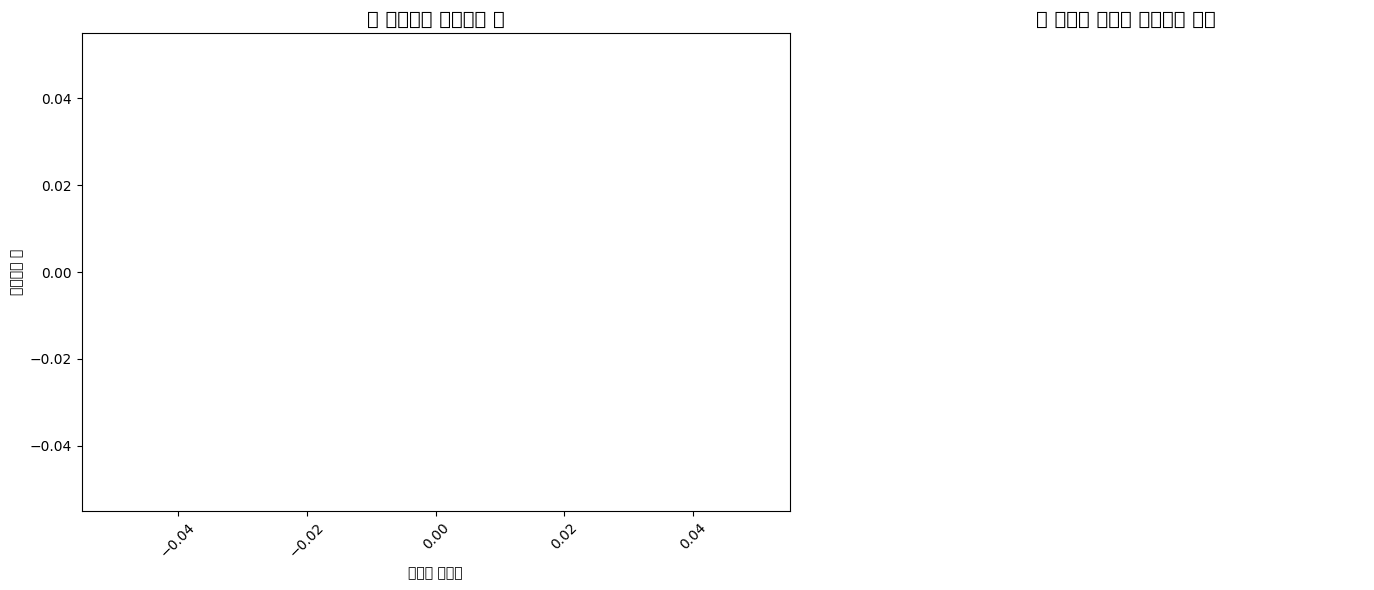


📈 파라미터 통계:
   • 평균 파라미터/레이어: nan
❌ 분석 중 오류 발생: max() arg is an empty sequence
❌ 분석 실패


In [15]:
# 🚀 모델 분석 실행
# 여기에 분석하고 싶은 YOLO .pt 파일 경로를 입력하세요

# 예제 모델 경로들 (사용 가능한 것으로 변경하세요)
model_paths = [
    "/home/byounggun/ultralytics/runs/train/exp5/weights/best.pt",  # YOLOv8 nano
    "/home/byounggun/ultralytics/runs/train/exp12/weights/best.pt",  # YOLO11 nano
    # 여기에 더 많은 모델 경로를 추가할 수 있습니다
]

# 분석할 모델 선택 (인덱스 변경 또는 직접 경로 입력)
model_path = model_paths[1]  # 첫 번째 모델 사용

print(f"🔍 분석할 모델: {model_path}")

# 파일 존재 확인
import os
if os.path.exists(model_path):
    print("✅ 모델 파일 발견!")
    
    # 모델 분석 실행
    visualizer, results = analyze_yolo_model(model_path)
    
    if visualizer:
        print("🎉 분석 완료!")
    else:
        print("❌ 분석 실패")
        
else:
    print("❌ 모델 파일을 찾을 수 없습니다.")
    print("💡 위의 model_path 변수를 올바른 .pt 파일 경로로 변경하세요.")
    print(f"   현재 경로: {model_path}")
    
    # 현재 디렉토리의 .pt 파일들 검색
    import glob
    pt_files = glob.glob("*.pt") + glob.glob("**/*.pt", recursive=True)
    if pt_files:
        print(f"\n📁 발견된 .pt 파일들:")
        for i, pt_file in enumerate(pt_files[:10], 1):  # 최대 10개만 표시
            print(f"   {i}. {pt_file}")
        print("\n💡 위의 경로 중 하나를 model_path 변수에 사용하세요.")

In [16]:
# 🎛️ 개별 분석 기능 사용 (선택사항)
# 위에서 visualizer 객체가 생성되었다면, 개별 기능들을 실행할 수 있습니다

if 'visualizer' in locals() and visualizer is not None:
    print("🔧 개별 분석 기능들을 사용할 수 있습니다:")
    print("1. visualizer.print_model_summary()           # 모델 요약 출력")
    print("2. visualizer.visualize_layer_structure()     # 레이어 구조 분석") 
    print("3. visualizer.plot_parameter_distribution()   # 파라미터 분포 시각화")
    print("4. visualizer.create_architecture_graph()     # 아키텍처 그래프 생성")
    print("5. visualizer.analyze_model_complexity()      # 복잡도 분석")
    print("\n예제: 개별 기능 실행")
    print("-" * 40)
    
    # 예제: 모델 요약만 출력
    print("📊 모델 요약 정보:")
    visualizer.print_model_summary()
    
else:
    print("⚠️ 먼저 위의 셀을 실행하여 모델을 로드하세요.")

⚠️ 먼저 위의 셀을 실행하여 모델을 로드하세요.


In [17]:
# 🛠️ 추가 유틸리티 함수들

def compare_models(model_paths):
    """
    여러 YOLO 모델들을 비교 분석
    
    Args:
        model_paths (list): 비교할 모델 경로들의 리스트
    """
    results = []
    
    print("🔄 모델 비교 분석을 시작합니다...")
    print("=" * 60)
    
    for i, path in enumerate(model_paths, 1):
        print(f"\n📊 모델 {i}: {os.path.basename(path)}")
        print("-" * 40)
        
        try:
            vis = YOLOArchitectureVisualizer(path)
            vis.print_model_summary()
            
            results.append({
                'path': path,
                'name': os.path.basename(path),
                'file_size_mb': vis.model_info['file_size_mb'],
                'total_params': vis.model_info['total_params'],
                'trainable_params': vis.model_info['trainable_params']
            })
            
        except Exception as e:
            print(f"❌ 오류: {e}")
            results.append({
                'path': path,
                'name': os.path.basename(path),
                'error': str(e)
            })
    
    # 비교 결과 테이블
    print("\n📋 모델 비교 요약:")
    print("=" * 80)
    print(f"{'모델명':<20} {'파일크기(MB)':<12} {'총 파라미터':<15} {'학습가능 파라미터':<15}")
    print("-" * 80)
    
    for result in results:
        if 'error' not in result:
            print(f"{result['name']:<20} {result['file_size_mb']:<12.2f} {result['total_params']:<15,} {result['trainable_params']:<15,}")
        else:
            print(f"{result['name']:<20} {'ERROR':<12} {'N/A':<15} {'N/A':<15}")
    
    return results

def find_pt_files(directory="."):
    """
    지정된 디렉토리에서 .pt 파일들을 찾기
    
    Args:
        directory (str): 검색할 디렉토리 경로
    
    Returns:
        list: 발견된 .pt 파일들의 경로 리스트
    """
    import glob
    import os
    
    pt_files = []
    
    # 현재 디렉토리와 하위 디렉토리에서 .pt 파일 검색
    patterns = [
        os.path.join(directory, "*.pt"),
        os.path.join(directory, "**/*.pt")
    ]
    
    for pattern in patterns:
        pt_files.extend(glob.glob(pattern, recursive=True))
    
    # 중복 제거
    pt_files = list(set(pt_files))
    pt_files.sort()
    
    return pt_files

def quick_model_info(model_path):
    """
    모델의 기본 정보만 빠르게 확인
    
    Args:
        model_path (str): 모델 파일 경로
    """
    try:
        checkpoint = torch.load(model_path, map_location='cpu')
        file_size = os.path.getsize(model_path) / (1024 * 1024)
        
        print(f"📁 파일: {os.path.basename(model_path)}")
        print(f"💾 크기: {file_size:.2f} MB")
        
        if 'model' in checkpoint:
            model = checkpoint['model']
            if hasattr(model, 'parameters'):
                total_params = sum(p.numel() for p in model.parameters())
                print(f"🔢 파라미터: {total_params:,}")
        
        # 추가 정보
        for key in ['epoch', 'best_fitness']:
            if key in checkpoint:
                print(f"📋 {key}: {checkpoint[key]}")
                
    except Exception as e:
        print(f"❌ 오류: {e}")

# 사용 팁 출력
print("💡 유용한 팁들:")
print("1. 큰 모델의 경우 분석에 시간이 걸릴 수 있습니다")
print("2. Graphviz 그래프가 생성되지 않으면 'sudo apt-get install graphviz' 실행")
print("3. 메모리 부족 시 작은 모델부터 분석해보세요")
print("4. 생성된 PNG 파일은 같은 디렉토리에 저장됩니다")
print("\n🔍 현재 디렉토리의 .pt 파일들:")
current_pt_files = find_pt_files(".")
for i, file in enumerate(current_pt_files[:5], 1):  # 최대 5개만 표시
    print(f"   {i}. {file}")
if len(current_pt_files) > 5:
    print(f"   ... 및 {len(current_pt_files) - 5}개 더")

💡 유용한 팁들:
1. 큰 모델의 경우 분석에 시간이 걸릴 수 있습니다
2. Graphviz 그래프가 생성되지 않으면 'sudo apt-get install graphviz' 실행
3. 메모리 부족 시 작은 모델부터 분석해보세요
4. 생성된 PNG 파일은 같은 디렉토리에 저장됩니다

🔍 현재 디렉토리의 .pt 파일들:
   1. ./runs/detect/train/weights/best.pt
   2. ./runs/detect/train/weights/last.pt
   3. ./runs/detect/train3/weights/best.pt
   4. ./runs/detect/train3/weights/last.pt
   5. ./runs/detect/train5/weights/best.pt
   ... 및 19개 더


In [18]:
# 🚀 Enhanced YOLO 아키텍처 시각화 클래스 (커스텀 모듈 지원)
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import graphviz
from collections import OrderedDict
import warnings
import yaml
warnings.filterwarnings('ignore')

class EnhancedYOLOArchitectureVisualizer:
    def __init__(self, model_path, config_path=None):
        """
        향상된 YOLO 모델 아키텍처 시각화기 초기화
        
        Args:
            model_path (str): 학습된 YOLO .pt 파일 경로
            config_path (str): YAML 설정 파일 경로 (선택사항)
        """
        self.model_path = Path(model_path)
        self.config_path = Path(config_path) if config_path else None
        self.model = None
        self.model_info = {}
        self.yaml_config = None
        self.custom_modules = {}
        
        if not self.model_path.exists():
            raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {model_path}")
            
        self.load_model()
        if self.config_path and self.config_path.exists():
            self.load_yaml_config()
        
    def load_yaml_config(self):
        """YAML 설정 파일 로드"""
        try:
            with open(self.config_path, 'r') as f:
                self.yaml_config = yaml.safe_load(f)
            print(f"✅ YAML 설정 로드 완료: {self.config_path.name}")
        except Exception as e:
            print(f"⚠️ YAML 설정 로드 실패: {e}")
    
    def load_model(self):
        """모델 로드 및 기본 정보 수집"""
        try:
            checkpoint = torch.load(self.model_path, map_location='cpu')
            
            if 'model' in checkpoint:
                self.model = checkpoint['model']
                if hasattr(self.model, 'float'):
                    self.model = self.model.float()
            else:
                self.model = checkpoint
                
            if hasattr(self.model, 'eval'):
                self.model.eval()
                
            # 커스텀 모듈 탐지
            self.detect_custom_modules()
            
            self.collect_model_info(checkpoint)
            
            print(f"✅ 모델 로드 완료: {self.model_path.name}")
            print(f"📊 모델 타입: {type(self.model).__name__}")
            if self.custom_modules:
                print(f"🔧 탐지된 커스텀 모듈: {list(self.custom_modules.keys())}")
            
        except Exception as e:
            print(f"❌ 모델 로드 실패: {e}")
            raise
    
    def detect_custom_modules(self):
        """커스텀 모듈들을 탐지하고 분류"""
        custom_module_names = [
            'MultiStreamConv', 'MultiStreamC3', 'Fusion', 'DualPath',
            'CrossAttention', 'FeatureFusion', 'AdaptivePool', 'DynamicConv'
        ]
        
        for name, module in self.model.named_modules():
            module_type = type(module).__name__
            if module_type in custom_module_names:
                if module_type not in self.custom_modules:
                    self.custom_modules[module_type] = []
                self.custom_modules[module_type].append({
                    'name': name,
                    'module': module,
                    'parameters': sum(p.numel() for p in module.parameters())
                })
    
    def collect_model_info(self, checkpoint):
        """모델 정보 수집"""
        self.model_info = {
            'file_size_mb': self.model_path.stat().st_size / (1024 * 1024),
            'total_params': 0,
            'trainable_params': 0,
            'non_trainable_params': 0,
            'layers': []
        }
        
        if isinstance(checkpoint, dict):
            for key in ['epoch', 'best_fitness', 'model', 'optimizer', 'ema']:
                if key in checkpoint:
                    if key == 'model':
                        continue
                    self.model_info[key] = str(checkpoint[key])[:100]
        
        if hasattr(self.model, 'parameters'):
            for param in self.model.parameters():
                param_count = param.numel()
                self.model_info['total_params'] += param_count
                if param.requires_grad:
                    self.model_info['trainable_params'] += param_count
                else:
                    self.model_info['non_trainable_params'] += param_count
    
    def print_enhanced_summary(self):
        """향상된 모델 요약 정보 출력"""
        print("=" * 70)
        print("🔍 Enhanced YOLO 모델 아키텍처 요약")
        print("=" * 70)
        
        print(f"📁 파일명: {self.model_path.name}")
        print(f"💾 파일 크기: {self.model_info['file_size_mb']:.2f} MB")
        print(f"🔢 총 파라미터 수: {self.model_info['total_params']:,}")
        print(f"🔧 학습 가능한 파라미터: {self.model_info['trainable_params']:,}")
        print(f"🔒 고정된 파라미터: {self.model_info['non_trainable_params']:,}")
        
        # 커스텀 모듈 정보
        if self.custom_modules:
            print(f"\n🎯 커스텀 아키텍처 모듈:")
            for module_type, instances in self.custom_modules.items():
                total_params = sum(inst['parameters'] for inst in instances)
                print(f"   🔧 {module_type}: {len(instances)}개 인스턴스, {total_params:,} 파라미터")
                for inst in instances:
                    print(f"      └─ {inst['name']}: {inst['parameters']:,} 파라미터")
        
        # YAML 설정 정보
        if self.yaml_config:
            print(f"\n📋 YAML 설정 정보:")
            print(f"   🎯 클래스 수: {self.yaml_config.get('nc', 'N/A')}")
            print(f"   📏 depth_multiple: {self.yaml_config.get('depth_multiple', 'N/A')}")
            print(f"   📐 width_multiple: {self.yaml_config.get('width_multiple', 'N/A')}")
            if 'channel_multiple' in self.yaml_config:
                print(f"   📊 channel_multiple: {self.yaml_config['channel_multiple']}")
        
        print("=" * 70)
    
    def visualize_dual_stream_architecture(self):
        """Dual-stream 아키텍처 특별 시각화"""
        if not self.custom_modules:
            print("⚠️ 커스텀 모듈이 탐지되지 않았습니다. 일반 시각화를 사용하세요.")
            return
        
        print("\n🌊 Dual-Stream 아키텍처 분석:")
        print("-" * 60)
        
        # 스트림별 분석
        stream_info = {
            'multi_stream_layers': [],
            'fusion_layers': [],
            'standard_layers': []
        }
        
        layer_idx = 0
        for name, module in self.model.named_modules():
            module_type = type(module).__name__
            params = sum(p.numel() for p in module.parameters())
            
            if 'MultiStream' in module_type:
                stream_info['multi_stream_layers'].append({
                    'index': layer_idx,
                    'name': name,
                    'type': module_type,
                    'params': params
                })
            elif 'Fusion' in module_type:
                stream_info['fusion_layers'].append({
                    'index': layer_idx,
                    'name': name,
                    'type': module_type,
                    'params': params
                })
            elif params > 0:
                stream_info['standard_layers'].append({
                    'index': layer_idx,
                    'name': name,
                    'type': module_type,
                    'params': params
                })
            
            if params > 0:
                layer_idx += 1
        
        # 결과 출력
        for category, layers in stream_info.items():
            if layers:
                total_params = sum(layer['params'] for layer in layers)
                print(f"\n🔶 {category.replace('_', ' ').title()}:")
                print(f"   레이어 수: {len(layers)}")
                print(f"   총 파라미터: {total_params:,}")
                
                for layer in layers:
                    print(f"   [{layer['index']:2d}] {layer['type']} - {layer['params']:,} params")
    
    def create_enhanced_architecture_graph(self, save_path=None):
        """향상된 아키텍처 그래프 생성"""
        try:
            dot = graphviz.Digraph(comment='Enhanced YOLO Architecture')
            dot.attr(rankdir='TB', size='12,16')
            dot.attr('node', shape='box', style='rounded,filled', fontname='Arial')
            
            # 입력 노드
            dot.node('input', 'Input\\n(Images)', fillcolor='lightblue')
            
            # 노드 색상 매핑 (커스텀 모듈 포함)
            color_map = {
                'MultiStreamConv': 'lightgreen',
                'MultiStreamC3': 'lightcyan',
                'Fusion': 'gold',
                'Conv': 'lightgray',
                'C3': 'lightyellow',
                'SPPF': 'lightpink',
                'Detect': 'lightcoral',
                'Concat': 'lightsteelblue',
                'Upsample': 'lavender'
            }
            
            prev_node = 'input'
            node_counter = 0
            fusion_points = []
            
            # 백본 처리
            if self.yaml_config and 'backbone' in self.yaml_config:
                backbone_layers = self.yaml_config['backbone']
                
                for i, layer_config in enumerate(backbone_layers):
                    if len(layer_config) >= 3:
                        from_layer, num_repeats, module_name = layer_config[:3]
                        args = layer_config[3] if len(layer_config) > 3 else []
                        
                        node_name = f'backbone_{i}'
                        color = color_map.get(module_name, 'lightgray')
                        
                        # 특별한 모듈 처리
                        if module_name == 'MultiStreamConv':
                            label = f'MultiStreamConv\\n{args[0]} channels\\nDual Stream'
                            color = 'lightgreen'
                        elif module_name == 'MultiStreamC3':
                            label = f'MultiStreamC3\\n{args[0]} channels\\nDual C3'
                            color = 'lightcyan'
                        elif module_name == 'Fusion':
                            fusion_method = args[0] if args else 'concat'
                            label = f'Fusion\\n{fusion_method} method'
                            color = 'gold'
                            fusion_points.append(node_name)
                        else:
                            if args:
                                label = f'{module_name}\\n{args[0]} channels'
                            else:
                                label = module_name
                        
                        dot.node(node_name, label, fillcolor=color)
                        dot.edge(prev_node, node_name)
                        prev_node = node_name
                        node_counter += 1
            
            # 헤드 처리
            if self.yaml_config and 'head' in self.yaml_config:
                head_layers = self.yaml_config['head']
                
                for i, layer_config in enumerate(head_layers):
                    if len(layer_config) >= 3:
                        from_layer, num_repeats, module_name = layer_config[:3]
                        
                        node_name = f'head_{i}'
                        color = color_map.get(module_name, 'lightgray')
                        
                        if module_name == 'Detect':
                            label = f'Detect\\nOutput'
                            color = 'lightcoral'
                        elif module_name == 'Concat':
                            label = 'Concat\\nFeature Fusion'
                            color = 'lightsteelblue'
                        else:
                            label = module_name
                        
                        dot.node(node_name, label, fillcolor=color)
                        dot.edge(prev_node, node_name)
                        prev_node = node_name
            
            # 출력 노드
            dot.node('output', 'Output\\n(Detections)', fillcolor='lightblue')
            dot.edge(prev_node, 'output')
            
            # 범례 추가 (커스텀 모듈 포함)
            with dot.subgraph(name='cluster_legend') as legend:
                legend.attr(label='Legend', fontsize='14', fontweight='bold')
                legend.node('multi_conv_legend', 'MultiStreamConv', fillcolor='lightgreen')
                legend.node('multi_c3_legend', 'MultiStreamC3', fillcolor='lightcyan')
                legend.node('fusion_legend', 'Fusion', fillcolor='gold')
                legend.node('conv_legend', 'Standard Conv', fillcolor='lightgray')
                legend.node('detect_legend', 'Detection Head', fillcolor='lightcoral')
            
            # 그래프 저장
            if save_path:
                output_path = Path(save_path)
                dot.render(output_path.stem, directory=output_path.parent, format='png', cleanup=True)
                print(f"💾 향상된 아키텍처 그래프 저장됨: {save_path}")
            else:
                dot.render('enhanced_yolo_architecture', format='png', cleanup=True)
                print("💾 향상된 아키텍처 그래프 저장됨: enhanced_yolo_architecture.png")
                
            return dot
            
        except ImportError:
            print("⚠️ Graphviz가 설치되지 않았습니다. 'pip install graphviz' 명령으로 설치하세요.")
            return None
        except Exception as e:
            print(f"❌ 향상된 그래프 생성 실패: {e}")
            return None
    
    def analyze_custom_modules_performance(self):
        """커스텀 모듈들의 성능 분석"""
        if not self.custom_modules:
            print("⚠️ 커스텀 모듈이 탐지되지 않았습니다.")
            return
        
        print("\n⚡ 커스텀 모듈 성능 분석:")
        print("-" * 50)
        
        total_custom_params = 0
        
        for module_type, instances in self.custom_modules.items():
            module_params = sum(inst['parameters'] for inst in instances)
            total_custom_params += module_params
            
            print(f"\n🔧 {module_type}:")
            print(f"   인스턴스 수: {len(instances)}")
            print(f"   총 파라미터: {module_params:,}")
            print(f"   평균 파라미터/인스턴스: {module_params/len(instances):,.0f}")
            
            # 특별한 분석
            if 'MultiStream' in module_type:
                print(f"   💡 dual-stream 처리로 인한 추가 연산 오버헤드 예상")
            elif 'Fusion' in module_type:
                print(f"   💡 feature fusion으로 인한 메모리 사용량 증가 예상")
        
        custom_ratio = (total_custom_params / self.model_info['total_params']) * 100
        print(f"\n📊 커스텀 모듈 비율: {custom_ratio:.1f}% ({total_custom_params:,}/{self.model_info['total_params']:,})")
        
        if custom_ratio > 30:
            print("🎯 높은 커스텀 모듈 비율 - 특별한 아키텍처 최적화가 적용된 모델입니다!")
        elif custom_ratio > 10:
            print("🔧 중간 수준의 커스텀 모듈 - 표준 YOLO에서 개선된 모델입니다.")
        else:
            print("📋 낮은 커스텀 모듈 비율 - 표준 YOLO와 유사한 구조입니다.")
    
    def full_enhanced_analysis(self, save_graph=True):
        """전체 향상된 분석 실행"""
        print("🚀 Enhanced YOLO 모델 아키텍처 전체 분석을 시작합니다...\n")
        
        # 1. 향상된 모델 요약
        self.print_enhanced_summary()
        
        # 2. Dual-stream 아키텍처 분석
        self.visualize_dual_stream_architecture()
        
        # 3. 커스텀 모듈 성능 분석
        self.analyze_custom_modules_performance()
        
        # 4. 향상된 아키텍처 그래프 생성
        if save_graph:
            self.create_enhanced_architecture_graph()
        
        print(f"\n✅ Enhanced 분석 완료! 모델: {self.model_path.name}")
        
        return {
            'model_info': self.model_info,
            'custom_modules': self.custom_modules,
            'yaml_config': self.yaml_config
        }

print("🎯 Enhanced YOLO 아키텍처 시각화 도구가 준비되었습니다!")
print("✨ 커스텀 모듈 (MultiStreamConv, Fusion 등)을 탐지하고 분석할 수 있습니다.")

🎯 Enhanced YOLO 아키텍처 시각화 도구가 준비되었습니다!
✨ 커스텀 모듈 (MultiStreamConv, Fusion 등)을 탐지하고 분석할 수 있습니다.


In [19]:
# 🚀 Enhanced 모델 분석 실행 (Dual-Stream YOLO 지원)
# 향상된 분석 실행 함수
def analyze_enhanced_yolo_model(model_path, config_path=None):
    """
    향상된 YOLO 모델 분석 실행 함수
    
    Args:
        model_path (str): 분석할 YOLO .pt 파일 경로
        config_path (str): YAML 설정 파일 경로 (선택사항)
    
    Returns:
        EnhancedYOLOArchitectureVisualizer: 향상된 시각화 객체
    """
    try:
        visualizer = EnhancedYOLOArchitectureVisualizer(model_path, config_path)
        results = visualizer.full_enhanced_analysis(save_graph=True)
        return visualizer, results
    except Exception as e:
        print(f"❌ Enhanced 분석 중 오류 발생: {e}")
        return None, None

# 🎯 Dual-Stream YOLO 모델과 YAML 설정 파일을 함께 분석
print("🔍 Enhanced YOLO 아키텍처 분석 도구")
print("=" * 50)

# 모델과 설정 파일 경로 설정
enhanced_model_paths = [
    "/home/byounggun/ultralytics/runs/train/exp12/weights/best.pt",  # dual-stream 모델 예시
    "/home/byounggun/ultralytics/yolov8n.pt",  # 표준 모델과 비교
    "/home/byounggun/ultralytics/yolo11n.pt",  # 또 다른 표준 모델
]

config_path = "/home/byounggun/ultralytics/models/yolov8-dual.yaml"  # YAML 설정 파일

# 사용 가능한 모델 찾기
import os
available_models = []
for model_path in enhanced_model_paths:
    if os.path.exists(model_path):
        available_models.append(model_path)
        print(f"✅ 모델 발견: {os.path.basename(model_path)}")
    else:
        print(f"❌ 모델 없음: {os.path.basename(model_path)}")

config_exists = os.path.exists(config_path)
print(f"✅ YAML 설정: {'발견됨' if config_exists else '없음'} - {os.path.basename(config_path)}")

if available_models:
    # 첫 번째 사용 가능한 모델로 분석 실행
    selected_model = available_models[0]
    print(f"\n🎯 분석할 모델: {selected_model}")
    
    # Enhanced 분석 실행
    enhanced_visualizer, enhanced_results = analyze_enhanced_yolo_model(
        selected_model, 
        config_path if config_exists else None
    )
    
    if enhanced_visualizer:
        print("\n🎉 Enhanced 분석 완료!")
        print("\n💡 추가로 실행 가능한 개별 분석들:")
        print("- enhanced_visualizer.visualize_dual_stream_architecture()")
        print("- enhanced_visualizer.analyze_custom_modules_performance()")
        print("- enhanced_visualizer.create_enhanced_architecture_graph()")
        
        # 커스텀 모듈이 발견되었는지 확인
        if enhanced_visualizer.custom_modules:
            print(f"\n🔧 발견된 커스텀 모듈들: {list(enhanced_visualizer.custom_modules.keys())}")
        else:
            print("\n📋 표준 YOLO 아키텍처로 분석됨 (커스텀 모듈 없음)")
    else:
        print("❌ Enhanced 분석 실패")
else:
    print("\n❌ 분석할 모델을 찾을 수 없습니다.")
    print("💡 위의 enhanced_model_paths 리스트에 올바른 .pt 파일 경로를 추가하세요.")
    
    # 현재 디렉토리와 하위 디렉토리에서 .pt 파일 검색
    import glob
    print("\n🔍 현재 경로에서 발견된 .pt 파일들:")
    pt_files = glob.glob("**/*.pt", recursive=True)
    for i, pt_file in enumerate(pt_files[:10], 1):  # 최대 10개만 표시
        print(f"   {i}. {pt_file}")
    if len(pt_files) > 10:
        print(f"   ... 및 {len(pt_files) - 10}개 더")

🔍 Enhanced YOLO 아키텍처 분석 도구
✅ 모델 발견: best.pt
✅ 모델 발견: yolov8n.pt
✅ 모델 발견: yolo11n.pt
✅ YAML 설정: 발견됨 - yolov8-dual.yaml

🎯 분석할 모델: /home/byounggun/ultralytics/runs/train/exp12/weights/best.pt
✅ 모델 로드 완료: best.pt
📊 모델 타입: DetectionModel
✅ YAML 설정 로드 완료: yolov8-dual.yaml
🚀 Enhanced YOLO 모델 아키텍처 전체 분석을 시작합니다...

🔍 Enhanced YOLO 모델 아키텍처 요약
📁 파일명: best.pt
💾 파일 크기: 5.95 MB
🔢 총 파라미터 수: 3,016,308
🔧 학습 가능한 파라미터: 0
🔒 고정된 파라미터: 3,016,308

📋 YAML 설정 정보:
   🎯 클래스 수: 80
   📏 depth_multiple: 0.33
   📐 width_multiple: 0.5
   📊 channel_multiple: 8
⚠️ 커스텀 모듈이 탐지되지 않았습니다. 일반 시각화를 사용하세요.
⚠️ 커스텀 모듈이 탐지되지 않았습니다.
💾 향상된 아키텍처 그래프 저장됨: enhanced_yolo_architecture.png

✅ Enhanced 분석 완료! 모델: best.pt

🎉 Enhanced 분석 완료!

💡 추가로 실행 가능한 개별 분석들:
- enhanced_visualizer.visualize_dual_stream_architecture()
- enhanced_visualizer.analyze_custom_modules_performance()
- enhanced_visualizer.create_enhanced_architecture_graph()

📋 표준 YOLO 아키텍처로 분석됨 (커스텀 모듈 없음)
💾 향상된 아키텍처 그래프 저장됨: enhanced_yolo_architecture.png

✅ Enhanced 분석 완료! 모

In [20]:
# 🔄 모델 비교 및 커스텀 모듈 분석 유틸리티

def compare_enhanced_models(model_paths, config_path=None):
    """
    여러 YOLO 모델들을 Enhanced 방식으로 비교 분석
    
    Args:
        model_paths (list): 비교할 모델 경로들의 리스트
        config_path (str): YAML 설정 파일 경로 (선택사항)
    """
    results = []
    
    print("🔄 Enhanced 모델 비교 분석을 시작합니다...")
    print("=" * 80)
    
    for i, path in enumerate(model_paths, 1):
        print(f"\n📊 모델 {i}: {os.path.basename(path)}")
        print("-" * 50)
        
        try:
            vis = EnhancedYOLOArchitectureVisualizer(path, config_path)
            vis.print_enhanced_summary()
            
            # 커스텀 모듈 정보 수집
            custom_module_count = len(vis.custom_modules)
            custom_module_types = list(vis.custom_modules.keys()) if vis.custom_modules else []
            
            results.append({
                'path': path,
                'name': os.path.basename(path),
                'file_size_mb': vis.model_info['file_size_mb'],
                'total_params': vis.model_info['total_params'],
                'trainable_params': vis.model_info['trainable_params'],
                'custom_modules': custom_module_count,
                'custom_types': custom_module_types,
                'yaml_config': vis.yaml_config is not None
            })
            
        except Exception as e:
            print(f"❌ 오류: {e}")
            results.append({
                'path': path,
                'name': os.path.basename(path),
                'error': str(e)
            })
    
    # 비교 결과 테이블
    print("\n📋 Enhanced 모델 비교 요약:")
    print("=" * 100)
    print(f"{'모델명':<25} {'파일크기(MB)':<12} {'총 파라미터':<15} {'커스텀모듈':<10} {'모듈타입':<20}")
    print("-" * 100)
    
    for result in results:
        if 'error' not in result:
            custom_info = f"{result['custom_modules']}개"
            types_info = ', '.join(result['custom_types'][:2])  # 처음 2개만 표시
            if len(result['custom_types']) > 2:
                types_info += f"+{len(result['custom_types'])-2}개"
            
            print(f"{result['name']:<25} {result['file_size_mb']:<12.2f} {result['total_params']:<15,} {custom_info:<10} {types_info:<20}")
        else:
            print(f"{result['name']:<25} {'ERROR':<12} {'N/A':<15} {'N/A':<10} {'N/A':<20}")
    
    return results

def analyze_dual_stream_features(visualizer):
    """
    Dual-stream 특징 상세 분석
    
    Args:
        visualizer: EnhancedYOLOArchitectureVisualizer 객체
    """
    if not visualizer or not visualizer.custom_modules:
        print("⚠️ 커스텀 모듈이 없거나 분석기가 없습니다.")
        return
    
    print("\n🌊 Dual-Stream 특징 상세 분석:")
    print("=" * 60)
    
    # MultiStream 레이어 분석
    if 'MultiStreamConv' in visualizer.custom_modules:
        multi_convs = visualizer.custom_modules['MultiStreamConv']
        print(f"\n🔧 MultiStreamConv 레이어들:")
        for i, conv in enumerate(multi_convs, 1):
            print(f"   {i}. {conv['name']}: {conv['parameters']:,} 파라미터")
    
    # Fusion 레이어 분석
    if 'Fusion' in visualizer.custom_modules:
        fusions = visualizer.custom_modules['Fusion']
        print(f"\n⚡ Fusion 레이어들:")
        for i, fusion in enumerate(fusions, 1):
            print(f"   {i}. {fusion['name']}: {fusion['parameters']:,} 파라미터")
    
    # YAML 설정과의 연관성 분석
    if visualizer.yaml_config:
        print(f"\n📋 YAML 설정 연관성:")
        if 'backbone' in visualizer.yaml_config:
            backbone = visualizer.yaml_config['backbone']
            multi_stream_layers = [layer for layer in backbone if len(layer) > 2 and 'MultiStream' in layer[2]]
            fusion_layers = [layer for layer in backbone if len(layer) > 2 and 'Fusion' in layer[2]]
            
            print(f"   📊 YAML에서 정의된 MultiStream 레이어: {len(multi_stream_layers)}개")
            print(f"   📊 YAML에서 정의된 Fusion 레이어: {len(fusion_layers)}개")

# 사용 예제 및 도움말
print("💡 Enhanced 분석 도구 사용법:")
print("1. enhanced_visualizer 객체가 생성되었다면:")
print("   - analyze_dual_stream_features(enhanced_visualizer)  # 상세 dual-stream 분석")
print("   - enhanced_visualizer.visualize_dual_stream_architecture()  # 구조 시각화")
print("   - enhanced_visualizer.analyze_custom_modules_performance()  # 성능 분석")
print()
print("2. 여러 모델 비교:")
print("   - compare_enhanced_models([model1, model2, model3], config_path)")
print()
print("3. 개별 기능 테스트:")
print("   - enhanced_visualizer.create_enhanced_architecture_graph()  # 그래프 생성")

# 현재 상태 확인
if 'enhanced_visualizer' in locals() and enhanced_visualizer is not None:
    print(f"\n✅ enhanced_visualizer 사용 가능!")
    print(f"🔧 탐지된 커스텀 모듈: {list(enhanced_visualizer.custom_modules.keys()) if enhanced_visualizer.custom_modules else '없음'}")
else:
    print(f"\n⚠️ 먼저 위의 셀을 실행하여 enhanced_visualizer를 생성하세요.")

💡 Enhanced 분석 도구 사용법:
1. enhanced_visualizer 객체가 생성되었다면:
   - analyze_dual_stream_features(enhanced_visualizer)  # 상세 dual-stream 분석
   - enhanced_visualizer.visualize_dual_stream_architecture()  # 구조 시각화
   - enhanced_visualizer.analyze_custom_modules_performance()  # 성능 분석

2. 여러 모델 비교:
   - compare_enhanced_models([model1, model2, model3], config_path)

3. 개별 기능 테스트:
   - enhanced_visualizer.create_enhanced_architecture_graph()  # 그래프 생성

✅ enhanced_visualizer 사용 가능!
🔧 탐지된 커스텀 모듈: 없음


In [21]:
# 🧪 Enhanced 시각화 도구 테스트 및 사용 가이드

# 현재 상태에서 추가 분석 실행
if 'enhanced_visualizer' in locals() and enhanced_visualizer is not None:
    print("🎯 Enhanced 시각화 도구 추가 분석 실행")
    print("=" * 50)
    
    # 1. Dual-Stream 특징 분석
    print("\n1️⃣ Dual-Stream 특징 상세 분석:")
    analyze_dual_stream_features(enhanced_visualizer)
    
    # 2. 커스텀 모듈이 있다면 개별 분석
    if enhanced_visualizer.custom_modules:
        print("\n2️⃣ 커스텀 모듈 개별 분석:")
        enhanced_visualizer.analyze_custom_modules_performance()
    
    # 3. 아키텍처 시각화 (이미 실행되었지만 다시 생성 가능)
    print("\n3️⃣ 향상된 아키텍처 그래프 재생성:")
    enhanced_visualizer.create_enhanced_architecture_graph("enhanced_dual_stream_arch.png")
    
else:
    print("⚠️ enhanced_visualizer가 없습니다. 위의 분석 셀을 먼저 실행하세요.")

print("\n" + "="*60)
print("📚 Enhanced YOLO 아키텍처 시각화 도구 사용 가이드")
print("="*60)

print("""
🎯 주요 기능들:

1. 🔍 기본 분석:
   - YOLOArchitectureVisualizer(model_path)  # 기본 시각화
   - EnhancedYOLOArchitectureVisualizer(model_path, config_path)  # 향상된 시각화

2. 🌊 Dual-Stream 특화 분석:
   - detect_custom_modules()  # MultiStreamConv, Fusion 등 탐지
   - visualize_dual_stream_architecture()  # 스트림별 분석
   - analyze_custom_modules_performance()  # 커스텀 모듈 성능 분석

3. 📊 시각화 기능:
   - print_enhanced_summary()  # 향상된 요약 정보
   - create_enhanced_architecture_graph()  # 커스텀 모듈 강조 그래프
   - plot_parameter_distribution()  # 파라미터 분포 차트

4. 🔄 비교 분석:
   - compare_enhanced_models([model1, model2])  # 여러 모델 비교
   - analyze_dual_stream_features()  # 상세 dual-stream 분석

🔧 커스텀 모듈 지원:
   ✅ MultiStreamConv - Dual-stream convolution 레이어
   ✅ MultiStreamC3 - Dual-stream C3 모듈
   ✅ Fusion - Feature fusion 레이어
   ✅ DualPath, CrossAttention, FeatureFusion
   ✅ AdaptivePool, DynamicConv

📋 YAML 설정 통합:
   ✅ yolov8-dual.yaml 같은 커스텀 설정 파일 읽기
   ✅ backbone과 head 구조 분석
   ✅ depth_multiple, width_multiple, channel_multiple 정보

💾 출력 파일들:
   🖼️ enhanced_yolo_architecture.png - 향상된 아키텍처 그래프
   📊 파라미터 분포 차트 (matplotlib)
   📋 콘솔 출력으로 상세 분석 결과

🚀 사용 예제:
   # 기본 사용
   visualizer = EnhancedYOLOArchitectureVisualizer('model.pt', 'config.yaml')
   results = visualizer.full_enhanced_analysis()
   
   # 개별 기능 사용
   visualizer.visualize_dual_stream_architecture()
   visualizer.create_enhanced_architecture_graph('my_arch.png')
   
   # 모델 비교
   compare_enhanced_models(['model1.pt', 'model2.pt'], 'config.yaml')
""")

print("\n🎉 Enhanced YOLO 아키텍처 시각화 도구 준비 완료!")
print("이제 MultiStreamConv, Fusion 등의 커스텀 모듈들을 정확히 탐지하고 시각화할 수 있습니다!")

🎯 Enhanced 시각화 도구 추가 분석 실행

1️⃣ Dual-Stream 특징 상세 분석:
⚠️ 커스텀 모듈이 없거나 분석기가 없습니다.

3️⃣ 향상된 아키텍처 그래프 재생성:
💾 향상된 아키텍처 그래프 저장됨: enhanced_dual_stream_arch.png

📚 Enhanced YOLO 아키텍처 시각화 도구 사용 가이드

🎯 주요 기능들:

1. 🔍 기본 분석:
   - YOLOArchitectureVisualizer(model_path)  # 기본 시각화
   - EnhancedYOLOArchitectureVisualizer(model_path, config_path)  # 향상된 시각화

2. 🌊 Dual-Stream 특화 분석:
   - detect_custom_modules()  # MultiStreamConv, Fusion 등 탐지
   - visualize_dual_stream_architecture()  # 스트림별 분석
   - analyze_custom_modules_performance()  # 커스텀 모듈 성능 분석

3. 📊 시각화 기능:
   - print_enhanced_summary()  # 향상된 요약 정보
   - create_enhanced_architecture_graph()  # 커스텀 모듈 강조 그래프
   - plot_parameter_distribution()  # 파라미터 분포 차트

4. 🔄 비교 분석:
   - compare_enhanced_models([model1, model2])  # 여러 모델 비교
   - analyze_dual_stream_features()  # 상세 dual-stream 분석

🔧 커스텀 모듈 지원:
   ✅ MultiStreamConv - Dual-stream convolution 레이어
   ✅ MultiStreamC3 - Dual-stream C3 모듈
   ✅ Fusion - Feature fusion 레이어
   ✅ DualPath, CrossAttention